In [1]:
MAX_FRAMES = 200
DIRS = ["./cornell", "./dragon", "./refracting-spheres"]
SHOW_PLOTS = False

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
FIX_PSNR = False

if FIX_PSNR:
    def fix_psnr(psnr):
        for i in range(len(psnr)):
            psnr[i] += 4.7712125471966243729502790325511530920012886419069586482986564030
        return psnr

    for dir in DIRS:
        with open("{}/errors.json".format(dir)) as file:
            data = json.load(file)

        for err in data["errors"].values():
            err["PSNR"] = fix_psnr(err["PSNR"])

        with open("{}/errors.json".format(dir), "w") as file:
            json.dump(data, file)

In [4]:
def to_numpy(conf):
    for e, values in conf.items():
        conf[e] = np.array(values)

    return conf

In [5]:
# Raw error plots

def plot_conf(plots, conf, label):
    for e, y in conf.items():
        max_len = np.minimum(len(y), MAX_FRAMES)
        y = y[:max_len]
        x = np.arange(1, len(y) + 1)

        if label == "hero":
            color = "tab:blue"
        elif label == "random":
            color = "tab:orange"
        else:
            color = "tab:green"

        ax = plots[e][1]
        ax.plot(x, y, label=label, color=color)

        ax.grid(visible=True)
        ax.set_xlabel('passes')
        ax.set_title("Variance" if e == "VAR" else e)

        handles,labels = ax.get_legend_handles_labels()
        handels, labels = zip(*sorted(zip(handles, labels), key=lambda t: t[1]))
        ax.legend(handles, labels)

        if e == "SSIM":
            ax.set_ylabel("similarity")
        elif e == "PSNR":
            ax.set_ylabel("ratio (dB)")
        else:
            ax.set_ylabel("absolute error")

In [6]:
def plot_all(dir, hero, random, path):
    error_plots = {
        "MSE": plt.subplots(),
        "PSE": plt.subplots(),
        "PSNR": plt.subplots(),
        "SSIM": plt.subplots(),
        "VAR": plt.subplots(),
    }

    plot_conf(error_plots, hero, "hero")
    plot_conf(error_plots, random, "random")
    if path is not None:
        plot_conf(error_plots, path, "path")

    for e, p in error_plots.items():
        fname = "{}/{}.png".format(dir, "Variance" if e == "VAR" else e)
        p[0].savefig(fname, dpi=200, bbox_inches='tight')

    if SHOW_PLOTS:
        plt.show()

In [9]:
def plot_ratios(dir, hero, random):
    fig, ax = plt.subplots()

    ranges = []

    for e, hero_y in sorted(hero.items()):
        if e == "PSE":
            continue
        if e == "PSNR" or e == "SSIM":
            label = "1 / " + e
            ratio = random[e] / hero_y
        else:
            label = "Variance" if e == "VAR" else e
            ratio = hero_y / random[e]

        if e == "PSNR":
            color = "darkred"
        elif e == "SSIM":
            color = "tab:orange"
        elif e == "MSE":
            color = "tab:blue"
        else:
            color = "tab:green"

        x = np.arange(1, len(ratio) + 1)
        ax.plot(x, ratio, label=label, color=color)

        print("{} ratio in range ({:.3f}, {:.3f}).".format(e, ratio.min(), ratio.max()))
        # if e == "VAR":
        #     print(hero_y[:10]);
        #     print(random[e][:10]);
        #     print(ratio[:10])

    ax.grid(visible=True)
    ax.set_xlabel("passes")
    ax.set_ylabel("ratio")
    ax.set_title("Ratio (hero / random)")

    handles,labels = ax.get_legend_handles_labels()
    handels, labels = zip(*sorted(zip(handles, labels), key=lambda t: t[1]))
    ax.legend(handels, labels, loc="best", bbox_to_anchor=(0.5, 0, 0.5, 0.5))

    fname = "{}/ratio.png".format(dir)
    fig.savefig(fname, dpi=200, bbox_inches='tight')

    if SHOW_PLOTS:
        plt.show()

./cornell:
MSE ratio in range (0.489, 0.837).
PSNR ratio in range (0.882, 0.923).
SSIM ratio in range (0.960, 1.000).
VAR ratio in range (0.815, 0.886).

./dragon:
MSE ratio in range (0.580, 0.849).
PSNR ratio in range (0.901, 0.942).
SSIM ratio in range (0.952, 1.000).
VAR ratio in range (0.857, 0.902).

./refracting-spheres:
MSE ratio in range (0.648, 0.894).
PSNR ratio in range (0.920, 0.961).
SSIM ratio in range (0.926, 0.999).
VAR ratio in range (0.848, 1.010).



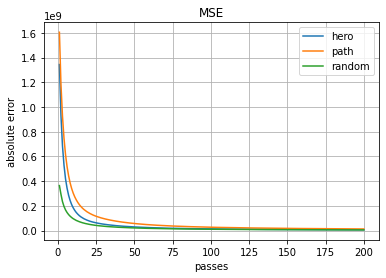

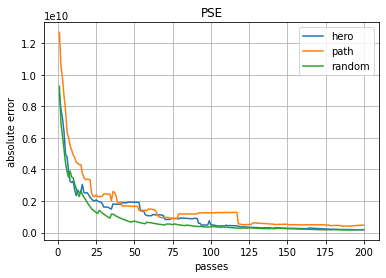

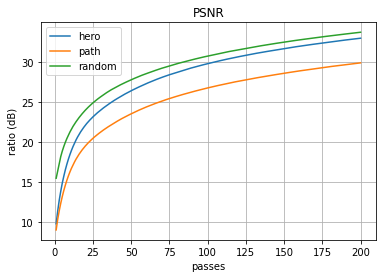

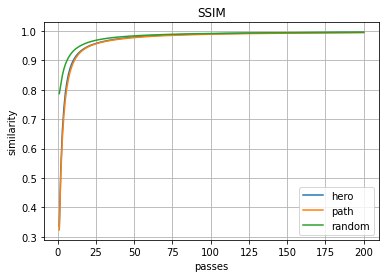

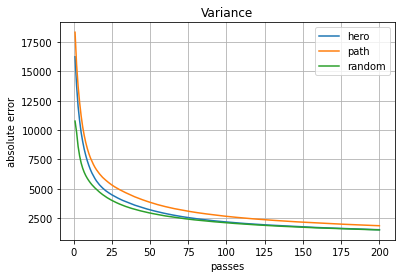

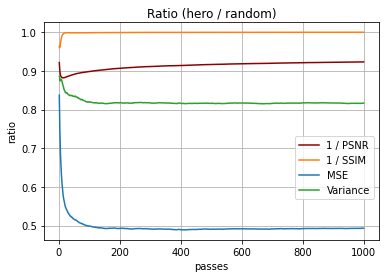

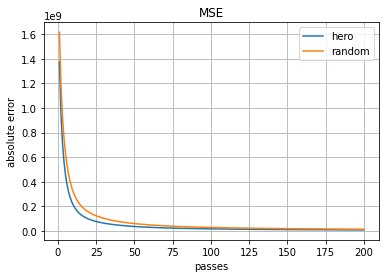

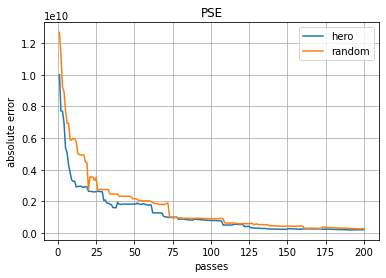

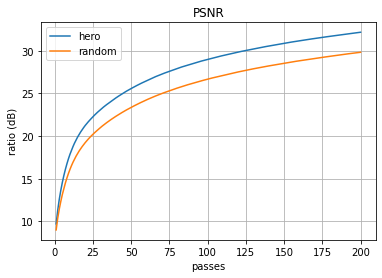

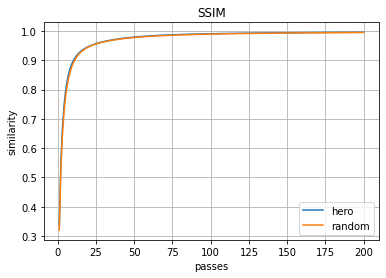

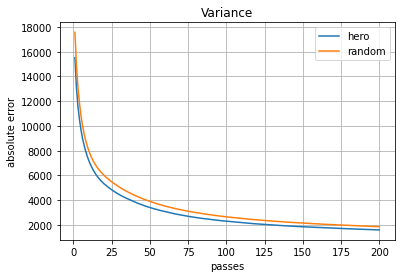

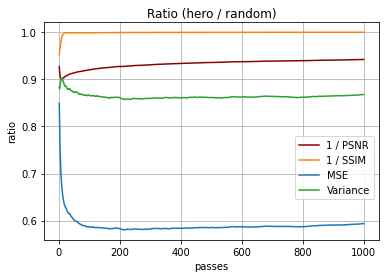

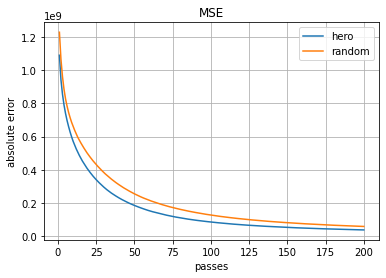

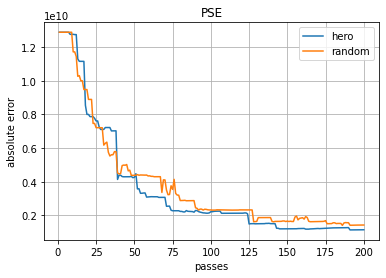

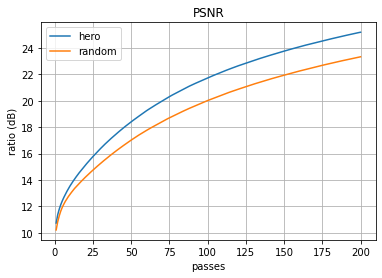

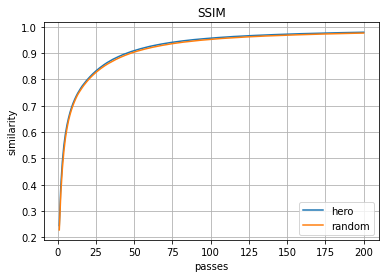

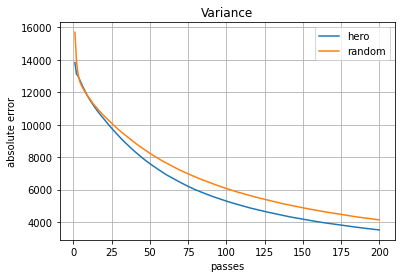

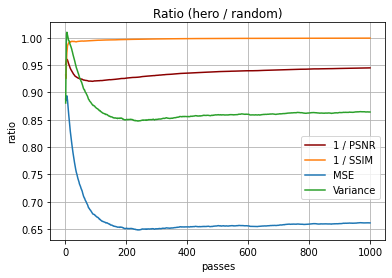

In [10]:
# load stuff

for dir in DIRS:
    print("{}:".format(dir))
    file = json.load(open("{}/errors.json".format(dir)))
    confs = file["errors"]
    hero = to_numpy(confs["hero"])
    random = to_numpy(confs["random"])
    if "path" in confs:
        path = to_numpy(confs["path"])
    else:
        path = None

    plot_all(dir, hero, random, path)
    plot_ratios(dir, hero, random)
    print()